In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
import fastai.basics as fai
import fastai.collab as fc
import fastai.tabular as ft

from pathlib import Path
from shutil import copyfile
import random
import gc

import torch
import torch.nn.functional as F
import torch.nn as nn

import torchvision
import torchvision.utils as utils
import torchvision.models
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
path = Path("Data/")

In [4]:
ratings = pd.read_csv(path/"rating.csv")

In [5]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [9]:
ratings = ratings[ratings['rating'] != -1]

In [10]:
ratings.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [11]:
animes = pd.read_csv(path/"anime.csv")

In [12]:
animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [14]:
ratings = ratings.merge(animes[["anime_id", "name"]])

In [18]:
ratings.shape

(6337239, 4)

In [19]:
fc.CollabDataBunch.from_df??

Signature:
fc.CollabDataBunch.from_df(
    ['ratings:pandas.core.frame.DataFrame', 'pct_val:float=0.2', 'user_name:Union[str, NoneType]=None', 'item_name:Union[str, NoneType]=None', 'rating_name:Union[str, NoneType]=None', 'test:pandas.core.frame.DataFrame=None', 'seed:int=None', "path:Union[pathlib.Path, str]='.'", 'bs:int=64', 'val_bs:int=None', 'num_workers:int=4', 'dl_tfms:Union[Collection[Callable], NoneType]=None', 'device:torch.device=None', 'collate_fn:Callable=<function data_collate at 0x7fa9873030d0>', 'no_check:bool=False'],
) -> 'CollabDataBunch'
Source:   
    @classmethod
    def from_df(cls, ratings:DataFrame, pct_val:float=0.2, user_name:Optional[str]=None, item_name:Optional[str]=None,
                rating_name:Optional[str]=None, test:DataFrame=None, seed:int=None, path:PathOrStr='.', bs:int=64, 
                val_bs:int=None, num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None, 
                device:torch.device=None, collate_fn:Callable=

In [33]:
data = fc.CollabDataBunch.from_df(ratings, seed=13, pct_val=0.1, item_name="name", bs=512)

In [22]:
data.show_batch()

user_id,name,target
1539,Haikyuu!! Second Season,10.0
58637,Onegai☆Teacher,10.0
27612,Fate/Zero,7.0
15321,Kore wa Zombie Desu ka? of the Dead OVA,10.0
4969,Seihou Bukyou Outlaw Star,8.0


In [23]:
y_range = [-0.5,10.5]

# Weight Decay removed :O

In [34]:
learner = fc.collab_learner(data, n_factors = 50, use_nn = False, y_range=y_range)

In [35]:
learner.model

EmbeddingDotBias(
  (u_weight): Embedding(69239, 50)
  (i_weight): Embedding(9836, 50)
  (u_bias): Embedding(69239, 1)
  (i_bias): Embedding(9836, 1)
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-01


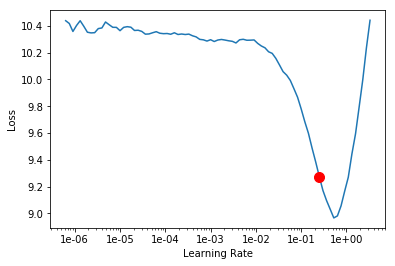

In [36]:
learner.lr_find(); learner.recorder.plot()

In [37]:
data.batch_size

512

In [39]:
learner.fit_one_cycle(1,1e-1)

epoch,train_loss,valid_loss
1,8.097679,8.065989


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


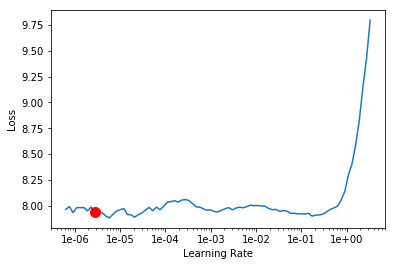

In [40]:
learner.lr_find(); learner.recorder.plot()

In [41]:
learner.fit_one_cycle(1,1e-5)

epoch,train_loss,valid_loss
1,8.003982,8.053472


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06


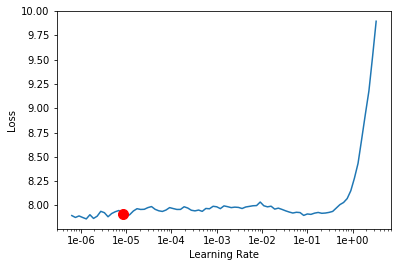

In [42]:
learner.lr_find(); learner.recorder.plot()

In [43]:
learner.fit_one_cycle(1,1e-6)

epoch,train_loss,valid_loss
1,7.968919,8.052761


In [45]:
learner.save('anime')

In [46]:
animes_num_ratings = ratings.groupby('name')['rating'].count()

In [47]:
animes_num_ratings.head()

name
&quot;0&quot;                                                         17
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu       1
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi                  635
&quot;Bungaku Shoujo&quot; Memoire                                   662
&quot;Bungaku Shoujo&quot; Movie                                    1295
Name: rating, dtype: int64

In [48]:
animes_num_ratings = animes_num_ratings.sort_values(ascending=False)

In [49]:
animes_num_ratings.head(20)

name
Death Note                            34226
Sword Art Online                      26310
Shingeki no Kyojin                    25290
Code Geass: Hangyaku no Lelouch       24126
Angel Beats!                          23565
Elfen Lied                            23528
Naruto                                22071
Fullmetal Alchemist: Brotherhood      21494
Fullmetal Alchemist                   21332
Code Geass: Hangyaku no Lelouch R2    21124
Toradora!                             20837
Highschool of the Dead                19488
Sen to Chihiro no Kamikakushi         19481
Clannad                               18746
Mirai Nikki (TV)                      18649
Ao no Exorcist                        17801
Steins;Gate                           17151
Another                               17036
Tengen Toppa Gurren Lagann            16955
Soul Eater                            16667
Name: rating, dtype: int64

In [50]:
animes_num_ratings.tail(10)

name
Hi-Speed Jecy                                1
Kinniku Banzuke: Kongou-kun no Daibouken!    1
I Love Sky                                   1
Jiok                                         1
His Lipstick                                 1
Ashita no Eleventachi                        1
Ashita e Mukau Hito                          1
Shounen Ninja Kaze no Fujimaru               1
Hi no Tori: Hagoromo-hen                     1
Mechakko Dotakon                             1
Name: rating, dtype: int64

In [51]:
most_watched = animes_num_ratings.index.values[:500]

In [52]:
most_watched[:10]

array(['Death Note', 'Sword Art Online', 'Shingeki no Kyojin', 'Code Geass: Hangyaku no Lelouch', 'Angel Beats!',
       'Elfen Lied', 'Naruto', 'Fullmetal Alchemist: Brotherhood', 'Fullmetal Alchemist',
       'Code Geass: Hangyaku no Lelouch R2'], dtype=object)

In [53]:
most_watched[-10:]

array(['Gunslinger Girl', 'Ghost in the Shell 2: Innocence', 'Seikon no Qwaser', 'Pokemon: The Origin',
       'Saenai Heroine no Sodatekata', 'Girls Bravo: First Season', 'Another: The Other - Inga', 'Sekaiichi Hatsukoi',
       'Paradise Kiss', 'Little Witch Academia'], dtype=object)

In [54]:
animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [55]:
animes.sort_values('rating',ascending=False).head(15)

,anime_id,name,genre,type,episodes,rating,members
10464,33662,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody",Movie,1,10.00,13
10400,30120,Spoon-hime no Swing Kitchen,"Adventure, Kids",TV,Unknown,9.60,47
9595,23005,Mogura no Motoro,Slice of Life,Movie,1,9.50,62
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
9078,33607,Kahei no Umi,Historical,Movie,1,9.33,44
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
10786,26313,Yakusoku: Africa Mizu to Midori,"Drama, Kids",OVA,1,9.25,53
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [56]:
A=animes.sort_values('rating',ascending=False)

In [57]:
A[A['members'] > 1000].head(20)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534


In [59]:
_,anime_names = learner.data.train_ds.x.classes.values()

In [60]:
anime_names

array(['#na#', '&quot;0&quot;', '&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu',
       '&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi', ..., 'xxxHOLiC Movie: Manatsu no Yoru no Yume',
       'xxxHOLiC Rou', 'xxxHOLiC Shunmuki', '◯'], dtype=object)

In [61]:
anime2id = {anime:i for i,anime in enumerate(anime_names)}

In [62]:
anime2id["Death Note"]

1670

In [63]:
most_watched_idx = [anime2id[name] for name in most_watched]

In [65]:
anime_bias = learner.model.i_bias(torch.tensor(most_watched_idx).cuda())

In [66]:
anime_bias = anime_bias.squeeze()

In [67]:
anime_bias[:4]

tensor([4.2374, 2.6578, 4.2655, 4.6378], device='cuda:0',
       grad_fn=<SliceBackward>)

In [68]:
mean_ratings = ratings.groupby("name")['rating'].mean()

In [69]:
mean_ratings.head()

name
&quot;0&quot;                                                       4.764706
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu    1.000000
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi                 7.343307
&quot;Bungaku Shoujo&quot; Memoire                                  7.744713
&quot;Bungaku Shoujo&quot; Movie                                    7.840154
Name: rating, dtype: float64

In [70]:
bias_anime_rating = [(b.item(), a, mean_ratings.loc[a]) for a,b in zip(most_watched,anime_bias)]

In [71]:
bias_anime_rating[:3]

[(4.237391948699951, 'Death Note', 8.83462864488985),
 (2.6578421592712402, 'Sword Art Online', 8.140212846826302),
 (4.265536308288574, 'Shingeki no Kyojin', 8.725741399762752)]

In [72]:
sorted(bias_anime_rating, key=lambda x: x[0], reverse=True)[:20]

[(6.166820049285889, 'Steins;Gate', 9.26132587021165),
 (6.110759258270264,
  'Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari',
  8.603178879310345),
 (6.098656177520752, 'Gintama', 9.23639774859287),
 (6.093326091766357, 'Hajime no Ippo', 8.954364615024573),
 (6.01948356628418, 'Suzumiya Haruhi no Shoushitsu', 8.907470703125),
 (6.008979797363281, 'Bakuman. 3rd Season', 8.838633686690224),
 (5.998951435089111, 'Fate/Zero 2nd Season', 8.817303978370028),
 (5.998554706573486, 'Shinsekai yori', 8.657247037374658),
 (5.946499824523926, 'Monster', 8.921304241235598),
 (5.939828872680664, 'Ookami Kodomo no Ame to Yuki', 8.932257091128546),
 (5.93222713470459, 'Berserk', 8.404622395833334),
 (5.905412673950195, 'Redline', 8.418420333424432),
 (5.8996357917785645, 'Nisemonogatari', 8.27505581012807),
 (5.837997913360596, 'Mononoke Hime', 8.807076540682798),
 (5.836575984954834, 'Clannad: After Story', 9.165291919061735),
 (5.815832614898682,
  'Fate/stay night: Unlimited Blade Wor

In [73]:
sorted(bias_anime_rating, key=lambda x: x[0])[:20]

[(1.5645619630813599, 'School Days', 6.486360167874857),
 (1.957366943359375, 'Dragon Ball GT', 6.867382726874178),
 (2.1982507705688477, 'Highschool of the Dead', 7.668462643678161),
 (2.1984269618988037, 'Rosario to Vampire', 7.381349241161505),
 (2.2855169773101807, 'Naruto', 7.893887907208554),
 (2.4640092849731445, 'Elfen Lied', 8.064433866031962),
 (2.6244101524353027, 'ChäoS;HEAd', 6.881771150334753),
 (2.6578421592712402, 'Sword Art Online', 8.140212846826302),
 (2.6779301166534424, 'Another', 8.044787508804884),
 (2.7251996994018555, 'Deadman Wonderland', 7.6662407722884724),
 (2.833176374435425, 'Vampire Knight', 7.681136344590631),
 (2.896123170852661,
  'Highschool of the Dead: Drifters of the Dead',
  6.829015544041451),
 (3.028416872024536, 'Amnesia', 6.637989778534924),
 (3.0499205589294434, '11eyes', 6.724036233410575),
 (3.0814719200134277, 'IS: Infinite Stratos', 7.337497134998854),
 (3.113293170928955, 'Green Green', 6.6961012135295634),
 (3.123845338821411, 'Vampire

In [74]:
most_watched = most_watched[:200]

In [76]:
anime_weights = learner.weight(most_watched, is_item=True)
anime_weights.shape

torch.Size([200, 50])

In [77]:
anime_pca = anime_weights.pca(3)
anime_pca.shape

torch.Size([200, 3])

In [78]:
def altos_y_bajos_en_eje(eje):
    anime_comp = [(f, i) for f,i in zip(anime_pca.t()[eje], most_watched)]
    L = sorted(anime_comp, key=lambda x: x[0], reverse=True)
    return L[:10], L[-10:]

In [79]:
altos_y_bajos_en_eje(0)

([(tensor(1.4887), 'Sekirei'),
  (tensor(1.4289), 'D.Gray-man'),
  (tensor(1.3952), 'Kuroshitsuji II'),
  (tensor(1.3504), 'Mondaiji-tachi ga Isekai kara Kuru Sou Desu yo?'),
  (tensor(1.1270), 'Shaman King'),
  (tensor(1.0885), 'Ookami Kodomo no Ame to Yuki'),
  (tensor(1.0525), 'Hyouka'),
  (tensor(0.8922), 'Bleach'),
  (tensor(0.8811), 'High School DxD New'),
  (tensor(0.8675), 'Black Lagoon')],
 [(tensor(-0.9015), 'Magi: The Labyrinth of Magic'),
  (tensor(-0.9283), 'Date A Live'),
  (tensor(-0.9468), 'Akira'),
  (tensor(-0.9508), 'Accel World'),
  (tensor(-0.9615), 'Sukitte Ii na yo.'),
  (tensor(-1.0243),
   'Bleach Movie 2: The DiamondDust Rebellion - Mou Hitotsu no Hyourinmaru'),
  (tensor(-1.0650), 'Kami nomi zo Shiru Sekai II'),
  (tensor(-1.1102), 'Free!'),
  (tensor(-1.1909), 'Nisemonogatari'),
  (tensor(-1.4836), 'Toaru Kagaku no Railgun')])

In [80]:
altos_y_bajos_en_eje(1)

([(tensor(1.7757), 'Fate/Zero 2nd Season'),
  (tensor(1.1944), 'Shakugan no Shana II (Second)'),
  (tensor(1.1019), 'Kill la Kill'),
  (tensor(1.0313), 'Toki wo Kakeru Shoujo'),
  (tensor(0.9636), 'K-On!!'),
  (tensor(0.9593), 'Baka to Test to Shoukanjuu Ni!'),
  (tensor(0.9186), 'Lovely★Complex'),
  (tensor(0.9153), 'Dragon Ball Z'),
  (tensor(0.8937), 'Fairy Tail'),
  (tensor(0.8923), 'Higurashi no Naku Koro ni Kai')],
 [(tensor(-0.8144), 'Sora no Otoshimono'),
  (tensor(-0.8172), 'Black Bullet'),
  (tensor(-0.8256), 'Kami nomi zo Shiru Sekai'),
  (tensor(-0.8376), 'Aldnoah.Zero'),
  (tensor(-0.8525), 'Sankarea'),
  (tensor(-0.8875), 'Final Fantasy VII: Advent Children'),
  (tensor(-0.9047), 'Ookami Kodomo no Ame to Yuki'),
  (tensor(-0.9717), 'Summer Wars'),
  (tensor(-1.5430), 'Fate/stay night: Unlimited Blade Works'),
  (tensor(-1.7340), 'Kami nomi zo Shiru Sekai II')])

In [81]:
altos_y_bajos_en_eje(2)

([(tensor(1.2961), 'Neon Genesis Evangelion: The End of Evangelion'),
  (tensor(1.0982), 'Kuroko no Basket 2nd Season'),
  (tensor(1.0837), 'Kore wa Zombie Desu ka? of the Dead'),
  (tensor(1.0360),
   'Bleach Movie 2: The DiamondDust Rebellion - Mou Hitotsu no Hyourinmaru'),
  (tensor(0.9462), 'Nisekoi'),
  (tensor(0.9394), 'Akira'),
  (tensor(0.9235), 'Kokoro Connect'),
  (tensor(0.9146), 'Baka to Test to Shoukanjuu Ni!'),
  (tensor(0.8821), 'Zero no Tsukaima: Princesses no Rondo'),
  (tensor(0.8550), 'FLCL')],
 [(tensor(-0.8387), 'Sukitte Ii na yo.'),
  (tensor(-0.8789), 'Howl no Ugoku Shiro'),
  (tensor(-0.8829), 'Rosario to Vampire Capu2'),
  (tensor(-0.9554), 'Shakugan no Shana II (Second)'),
  (tensor(-0.9583), 'Clannad: Mou Hitotsu no Sekai, Tomoyo-hen'),
  (tensor(-0.9625), 'Nanatsu no Taizai'),
  (tensor(-1.1394), 'Akame ga Kill!'),
  (tensor(-1.2309), 'K'),
  (tensor(-1.4559), 'Seitokai Yakuindomo'),
  (tensor(-1.4801), 'InuYasha')])